In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import tqdm


2025-01-10 10:53:36.685014: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 10:53:36.694776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736502816.706415  222792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736502816.709961  222792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 10:53:36.722691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_ID_small.pt").float()[:, 0:50, 0:3]

/tmp/maglowac/ipykernel_222792/2256734131.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_I

In [3]:
def log_data(data):

    logged_data = data.clone()  # Create a clone to keep the original data unchanged
    first_column = logged_data[:, :, 0]  # Extract the first column

    # Apply np.log where the values are non-zero
    mask = first_column != 0  # Mask for non-zero values
    first_column[mask] = torch.log(first_column[mask])  # Apply log only to non-zero entries


    data[:, :, 0] = first_column

    return data

In [4]:
bkg_data = log_data(bkg_data)

In [5]:
bkg_data.shape

torch.Size([291131, 200, 3])

In [6]:
def compute_emd(event1, event2):
    """
    Compute the Earth Mover's Distance between two events, handling zero-padded particles.
    Args:
        event1 (torch.Tensor): Shape (num_particles, num_features).
        event2 (torch.Tensor): Shape (num_particles, num_features).
    Returns:
        float: EMD value.
    """
    # Convert tensors to numpy arrays for POT
    #event1 = event1.cpu().numpy()
    #event2 = event2.cpu().numpy()

    # Identify real (non-zero) particles
    non_zero_mask1 = np.any(event1 != 0, axis=-1)  # Shape (200,)
    non_zero_mask2 = np.any(event2 != 0, axis=-1)  # Shape (200,)
    
    # Select non-zero particles
    real_particles1 = event1[non_zero_mask1]  # Only keep real particles
    real_particles2 = event2[non_zero_mask2]
    
    num_particles1 = real_particles1.shape[0]
    num_particles2 = real_particles2.shape[0]

    # Weights: uniform for real particles, zero for padded particles
    weights1 = np.ones(num_particles1) / num_particles1  # (1 / num_real_particles1,)
    weights2 = np.ones(num_particles2) / num_particles2  # (1 / num_real_particles2,)

    # Compute pairwise cost matrix (L2 distance)
    cost_matrix = np.linalg.norm(real_particles1[:, None, :] - real_particles2[None, :, :], axis=-1)

    # Compute EMD using POT
    emd_value = ot.emd2(weights1, weights2, cost_matrix)  # EMD^2
    return np.sqrt(emd_value)  # Take square root to get EMD

In [7]:
event1 = bkg_data[0].cpu().numpy()
event2 = bkg_data[50].cpu().numpy()

In [8]:
emd_value = compute_emd(event1, event2)

In [9]:
emd_value

1.0556136624967467

Computing EMD: 100%|██████████| 50000/50000 [00:13<00:00, 3706.18it/s]


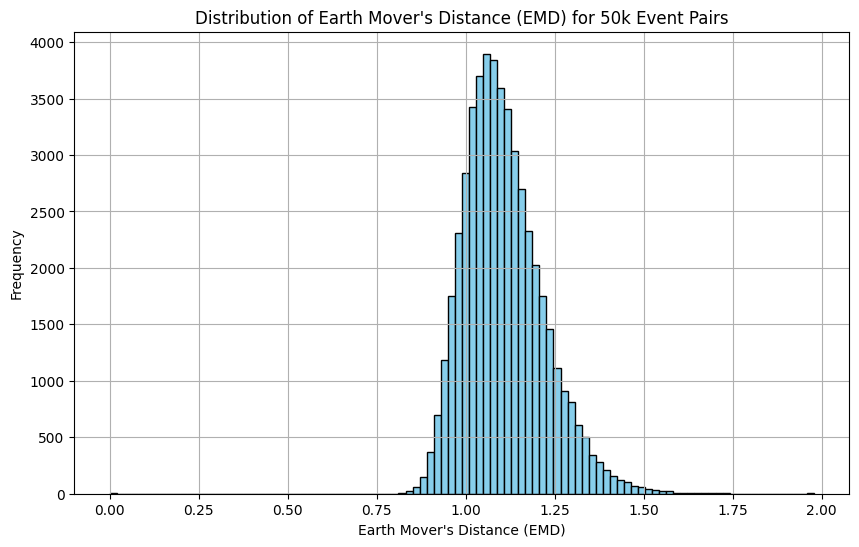

In [10]:
# Function to compute Earth Mover's Distance
def compute_emd(event1, event2):
    """
    Compute the Earth Mover's Distance between two events, handling zero-padded particles.
    Args:
        event1 (numpy.ndarray): Shape (num_particles, num_features).
        event2 (numpy.ndarray): Shape (num_particles, num_features).
    Returns:
        float: EMD value.
    """
    # Identify real (non-zero) particles
    non_zero_mask1 = np.any(event1 != 0, axis=-1)  # Shape (200,)
    non_zero_mask2 = np.any(event2 != 0, axis=-1)  # Shape (200,)
    
    # Select non-zero particles
    real_particles1 = event1[non_zero_mask1]  # Only keep real particles
    real_particles2 = event2[non_zero_mask2]
    
    # If either event is completely zero-padded, return a default EMD
    if real_particles1.shape[0] == 0 or real_particles2.shape[0] == 0:
        return float(0)  # or assign a default EMD value for empty events
    
    num_particles1 = real_particles1.shape[0]
    num_particles2 = real_particles2.shape[0]

    # Weights: uniform for real particles
    weights1 = np.ones(num_particles1) / num_particles1
    weights2 = np.ones(num_particles2) / num_particles2

    # Compute pairwise cost matrix (L2 distance)
    cost_matrix = np.linalg.norm(real_particles1[:, None, :] - real_particles2[None, :, :], axis=-1)

    # Compute EMD using POT
    emd_value = ot.emd2(weights1, weights2, cost_matrix)  # EMD^2
    return np.sqrt(emd_value)  # Take square root to get actual EMD
# Number of random event pairs
num_events = 50000
emd_values = []

# Compute EMD for 50,000 random pairs of events
for _ in tqdm(range(num_events), desc="Computing EMD"):
    idx1, idx2 = np.random.randint(0, len(bkg_data), size=2)  # Randomly select two events
    event1 = bkg_data[idx1].cpu().numpy()  # Convert to numpy array
    event2 = bkg_data[idx2].cpu().numpy()  # Convert to numpy array
    emd_value = compute_emd(event1, event2)
    emd_values.append(emd_value)

# Plot the distribution of EMD values
plt.figure(figsize=(10, 6))
plt.hist(emd_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Earth Mover\'s Distance (EMD) for 50k Event Pairs')
plt.xlabel('Earth Mover\'s Distance (EMD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
def precompute_emd_pairs(data, num_pairs=100000):

    N = data.shape[0]
    indices_i = np.random.randint(0, N, size=num_pairs)
    indices_j = np.random.randint(0, N, size=num_pairs)
    
    # Prepare arrays to store
    pairs_A = []
    pairs_B = []
    emd_vals = []
    
    for k in range(num_pairs):
        i, j = indices_i[k], indices_j[k]
        A = data[i]  # shape (200, 3)
        B = data[j]  # shape (200, 3)
        
        emd_val = compute_emd(A.cpu().numpy(), B.cpu().numpy())

        if emd_val == float(0):
            continue
        
        pairs_A.append(A.unsqueeze(0))  # shape (1, 200, 3)
        pairs_B.append(B.unsqueeze(0))
        emd_vals.append(emd_val)
        
        if (k+1) % 1000 == 0:
            print(f"Computed EMD for {k+1}/{num_pairs} pairs")
    
    pairs_A = torch.cat(pairs_A, dim=0)  # (num_pairs, 200, 3)
    pairs_B = torch.cat(pairs_B, dim=0)
    emd_vals = torch.tensor(emd_vals, dtype=torch.float)  # (num_pairs,)
    
    return pairs_A, pairs_B, emd_vals


In [12]:
pairs_A, paris_B, emd_vals = precompute_emd_pairs(bkg_data)

Computed EMD for 1000/100000 pairs
Computed EMD for 2000/100000 pairs
Computed EMD for 3000/100000 pairs
Computed EMD for 4000/100000 pairs
Computed EMD for 5000/100000 pairs
Computed EMD for 6000/100000 pairs
Computed EMD for 7000/100000 pairs
Computed EMD for 8000/100000 pairs
Computed EMD for 9000/100000 pairs
Computed EMD for 10000/100000 pairs
Computed EMD for 11000/100000 pairs
Computed EMD for 12000/100000 pairs
Computed EMD for 13000/100000 pairs
Computed EMD for 14000/100000 pairs
Computed EMD for 15000/100000 pairs
Computed EMD for 16000/100000 pairs
Computed EMD for 17000/100000 pairs
Computed EMD for 18000/100000 pairs
Computed EMD for 19000/100000 pairs
Computed EMD for 20000/100000 pairs
Computed EMD for 21000/100000 pairs
Computed EMD for 22000/100000 pairs
Computed EMD for 23000/100000 pairs
Computed EMD for 24000/100000 pairs
Computed EMD for 25000/100000 pairs
Computed EMD for 26000/100000 pairs
Computed EMD for 27000/100000 pairs
Computed EMD for 28000/100000 pairs
C

In [13]:
seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For fully reproducible cuDNN convolution operations:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
class EMDPairDataset(Dataset):

    def __init__(self, pairs_A, pairs_B, emd_vals):

        self.pairs_A = pairs_A
        self.pairs_B = pairs_B
        self.emd_vals = emd_vals

    def __len__(self):
        return self.pairs_A.shape[0]

    def __getitem__(self, idx):
        return self.pairs_A[idx], self.pairs_B[idx], self.emd_vals[idx]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def build_padding_mask(x, eps=1e-8):
    """
    x: shape (B, N, d_in).
        Example: (B, 200, 3).

    Returns a boolean mask of shape (B, N) where:
      True  = this token is PAD (ignore in attention)
      False = this token is real data
    """
    # If the sum of absolute values is < eps, call it padded
    # shape of mask = (B, N)
    return (x.abs().sum(dim=-1) < eps)

def masked_mean(x, mask):
    """
    x: shape (B, N, d_model)
    mask: shape (B, N), True means "PAD, ignore"
    
    Returns a pooled tensor of shape (B, d_model) that 
    averages only over unmasked (real) tokens.
    """
    # invert mask to get "True = keep" for real tokens
    keep = ~mask  # shape (B, N)
    keep = keep.unsqueeze(-1)  # shape (B, N, 1)
    
    # zero out positions that are mask=True
    x_masked = x * keep
    
    # sum over the N dimension
    sum_x = x_masked.sum(dim=1)  # shape (B, d_model)
    # how many tokens to divide by?
    count = keep.sum(dim=1)      # shape (B, 1)
    
    # Avoid dividing by zero
    avg = sum_x / (count + 1e-8)
    return avg

class ParticleEmbedding(nn.Module):
    """
    Basic embedding layer for per-particle features.
    Converts (B, N, d_in) -> (B, N, d_model).
    """
    def __init__(self, d_in, d_model):
        super().__init__()
        self.linear = nn.Linear(d_in, d_model)
        
    def forward(self, x):
        return self.linear(x)  # shape: (B, N, d_model)




class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # Self-attention within the same set
        attn_out, _ = self.self_attn(x, x, x)
        x = self.ln1(x + attn_out)
        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x

class CrossAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x_q, x_kv):
        # Cross-attention where x_q attends to x_kv
        attn_out, _ = self.cross_attn(x_q, x_kv, x_kv)
        x_q = self.ln1(x_q + attn_out)
        ff_out = self.ff(x_q)
        x_q = self.ln2(x_q + ff_out)
        return x_q

class CrossAttentionTransformer(nn.Module):
    """
    Transformer with both self-attention and cross-attention blocks.
    """
    def __init__(self, d_in=3, d_model=64, n_heads=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_projection = nn.Linear(d_in, d_model)

        # Self-attention and cross-attention layers
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "self_attn_A": SelfAttentionBlock(d_model, n_heads, dim_feedforward, dropout),
                "self_attn_B": SelfAttentionBlock(d_model, n_heads, dim_feedforward, dropout),
                "cross_attn_A_to_B": CrossAttentionBlock(d_model, n_heads, dim_feedforward, dropout),
                "cross_attn_B_to_A": CrossAttentionBlock(d_model, n_heads, dim_feedforward, dropout),
            })
            for _ in range(num_layers)
        ])

        # Final MLP
        self.mlp_out = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, A, B):
        # Project inputs to d_model dimension
        A = self.input_projection(A)  # (B, 200, d_model)
        B = self.input_projection(B)  # (B, 200, d_model)

        for layer in self.layers:
            # Self-attention for each set
            A = layer["self_attn_A"](A)
            B = layer["self_attn_B"](B)

            # Cross-attention between sets
            A = layer["cross_attn_A_to_B"](A, B)
            B = layer["cross_attn_B_to_A"](B, A)

        # Aggregate by mean pooling
        A_agg = A.mean(dim=1)  # (B, d_model)
        B_agg = B.mean(dim=1)  # (B, d_model)

        # Concatenate A and B representations and pass through final MLP
        AB = torch.cat([A_agg, B_agg], dim=-1)  # (B, 2 * d_model)
        out = self.mlp_out(AB)  # (B, 1)
        return out.squeeze(-1)

    

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def weighted_l1_loss(y_pred, y_true, weight_factor=2.0):
    # Compute the absolute error
    abs_error = torch.abs(y_true - y_pred)
    # Compute weights: larger errors receive higher weights
    weights = 1 + weight_factor * (abs_error > abs_error.mean()).float()
    weighted_loss = weights * abs_error
    return weighted_loss.mean()

# Training function
def train_transformer_model(pairs_A, pairs_B, emd_vals, batch_size=32, epochs=100, patience=5, device='cuda'):
    """
    Train, validate, and test the Transformer model.
    Includes early stopping and MinMax scaling of EMD values.
    """
    # 1. Normalize EMD values using MinMaxScaler
    scaler = MinMaxScaler()
    emd_vals = scaler.fit_transform(emd_vals.reshape(-1, 1)).flatten()  # Scale to [0, 1]

    # 2. Split data into training (80%), validation (10%), and testing (10%)
    total_size = len(emd_vals)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    dataset = EMDPairDataset(pairs_A, pairs_B, torch.tensor(emd_vals, dtype=torch.float))
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # 3. Define model, optimizer, and loss
    model = CrossAttentionTransformer(
        d_in=3, d_model=256, n_heads=8, num_layers=4, dim_feedforward=256, dropout=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Increased LR for stability
    loss_fn = lambda y_pred, y_true: weighted_l1_loss(y_pred, y_true, weight_factor=25.0)

    best_val_loss = float('inf')
    patience_counter = 0

    # 4. Training loop with early stopping
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for batch_A, batch_B, batch_emd in train_loader:
            batch_A = batch_A.to(device)
            batch_B = batch_B.to(device)
            batch_emd = batch_emd.to(device)

            optimizer.zero_grad()
            pred_emd = model(batch_A, batch_B)
            loss = loss_fn(pred_emd, batch_emd)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # 5. Validation loss
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_A, batch_B, batch_emd in val_loader:
                batch_A = batch_A.to(device)
                batch_B = batch_B.to(device)
                batch_emd = batch_emd.to(device)

                pred_emd = model(batch_A, batch_B)
                loss = loss_fn(pred_emd, batch_emd)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Plot the distribution of predictions vs true EMD for the test set
        true_emd_vals = []
        pred_emd_vals = []

        with torch.no_grad():
            for batch_A, batch_B, batch_emd in test_loader:
                batch_A = batch_A.to(device)
                batch_B = batch_B.to(device)
                batch_emd = batch_emd.to(device)

                pred_emd = model(batch_A, batch_B)
                true_emd_vals.extend(batch_emd.cpu().numpy().flatten())
                pred_emd_vals.extend(pred_emd.cpu().numpy().flatten())

        # Inverse transform to original EMD scale
        true_emd_vals = scaler.inverse_transform(np.array(true_emd_vals).reshape(-1, 1)).flatten()
        pred_emd_vals = scaler.inverse_transform(np.array(pred_emd_vals).reshape(-1, 1)).flatten()

        # Compute common bin edges based on the range of both distributions
        all_vals = np.concatenate([true_emd_vals, pred_emd_vals])
        bins = np.linspace(all_vals.min(), all_vals.max(), 50)  # 50 bins across the full range

        plt.figure(figsize=(10, 6))
        plt.hist(true_emd_vals, bins=bins, alpha=0.5, label='True EMD')
        plt.hist(pred_emd_vals, bins=bins, alpha=0.5, label='Predicted EMD')
        plt.xlabel('Earth Mover\'s Distance (EMD)')
        plt.ylabel('Count')
        plt.title(f'Distribution of True vs Predicted EMD on Testing Set (Epoch {epoch+1})')
        plt.legend()
        plt.show()

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # reset patience counter if validation improves
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping: Validation loss did not improve for 5 consecutive epochs.")
            break

        torch.save(model.state_dict(), 'transformed_emd.pth')

    print("Training complete.")
    return model


[Epoch 1/10] Train Loss: 1.5734, Val Loss: 1.3428


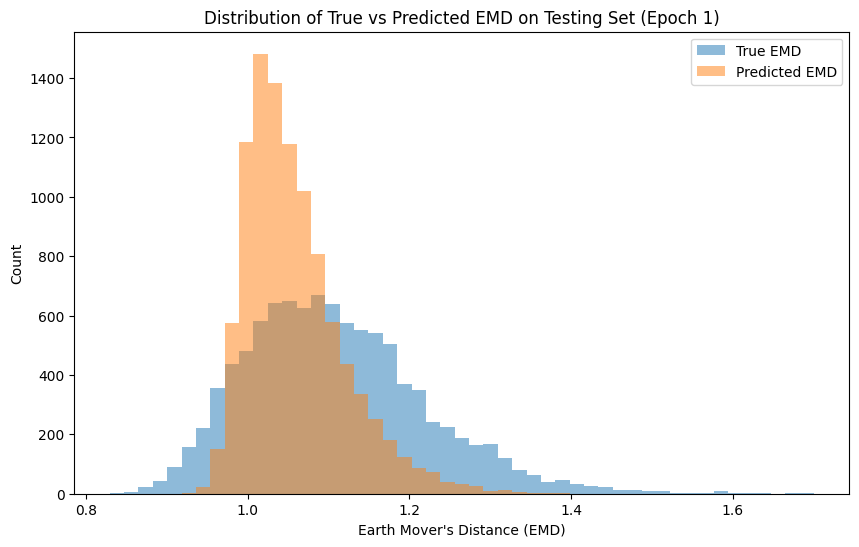

[Epoch 2/10] Train Loss: 0.8866, Val Loss: 0.7017


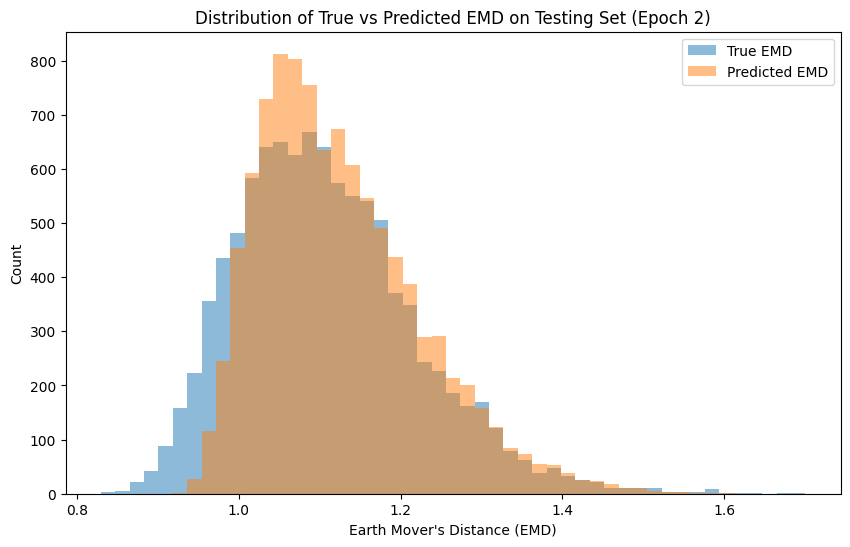

[Epoch 3/10] Train Loss: 0.6739, Val Loss: 0.6159


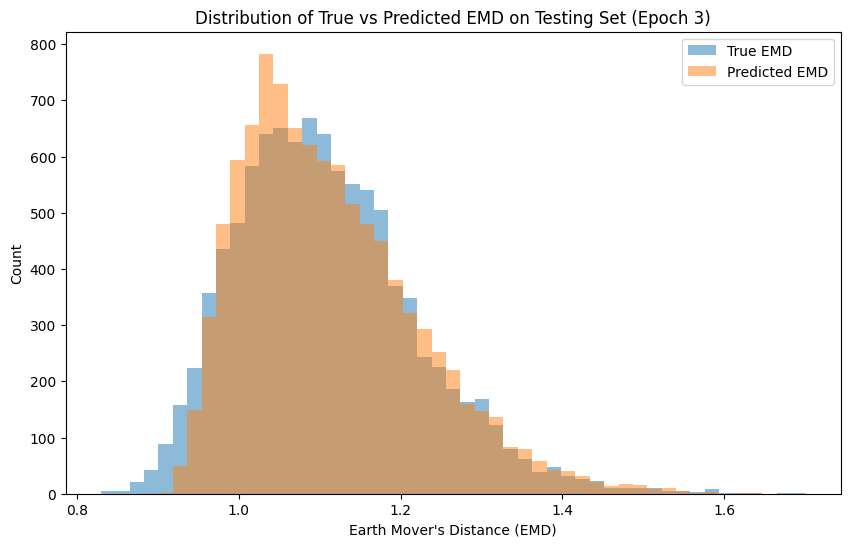

[Epoch 4/10] Train Loss: 0.6031, Val Loss: 0.6433


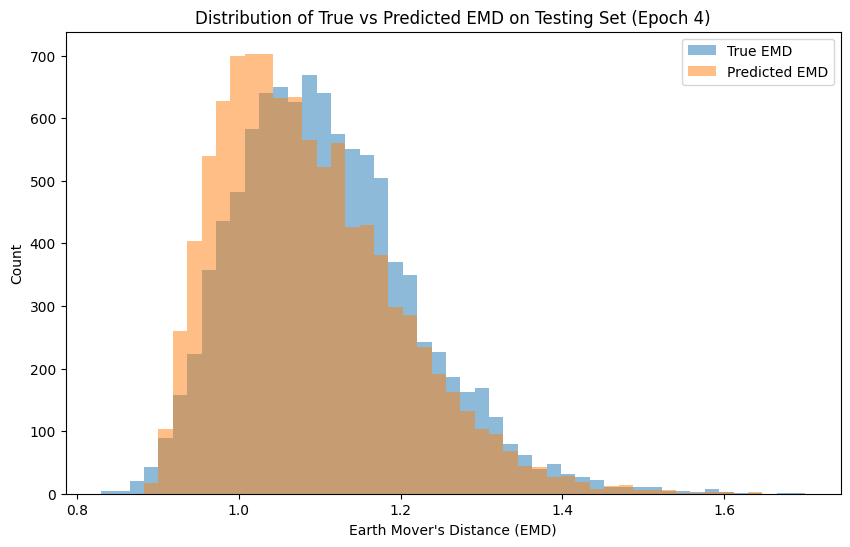

[Epoch 5/10] Train Loss: 0.5547, Val Loss: 0.7086


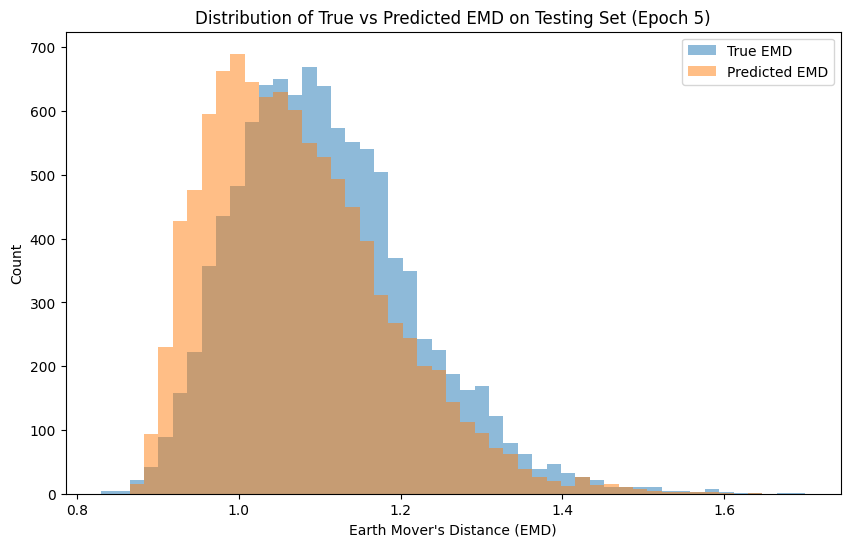

[Epoch 6/10] Train Loss: 0.5221, Val Loss: 0.5217


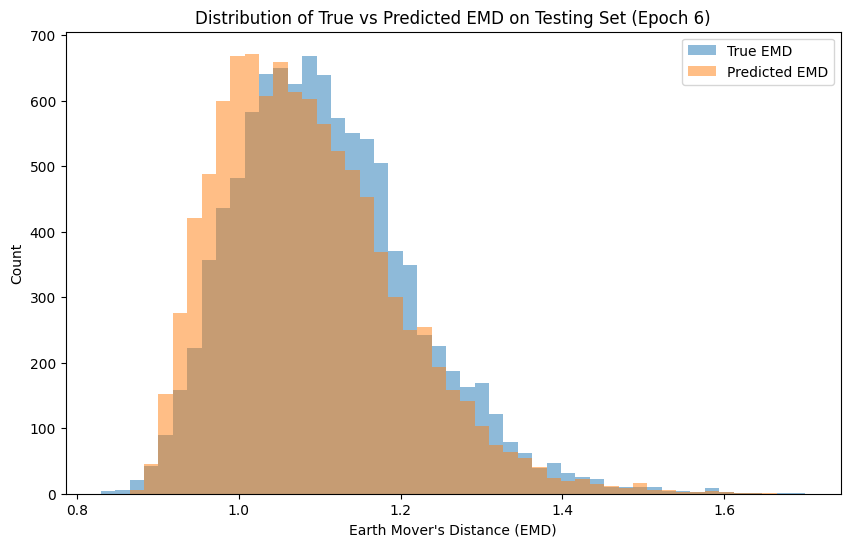

[Epoch 7/10] Train Loss: 0.4953, Val Loss: 0.6198


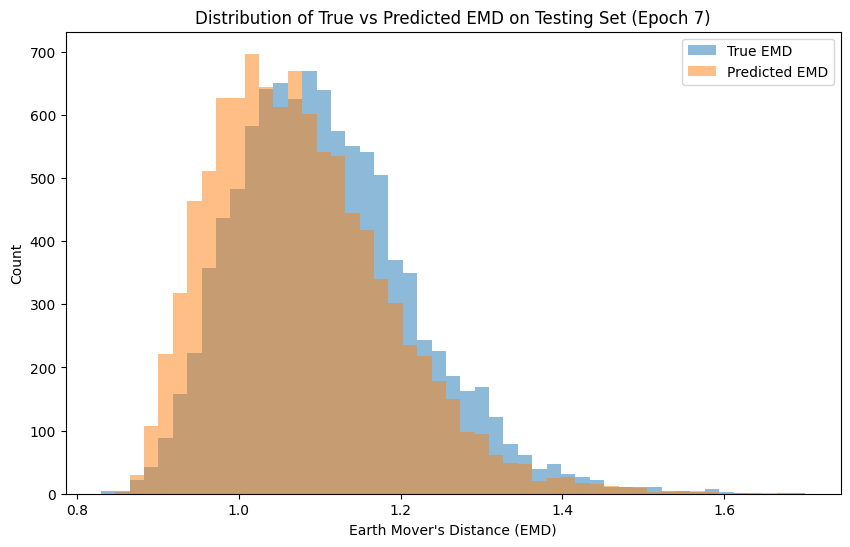

[Epoch 8/10] Train Loss: 0.4606, Val Loss: 0.5539


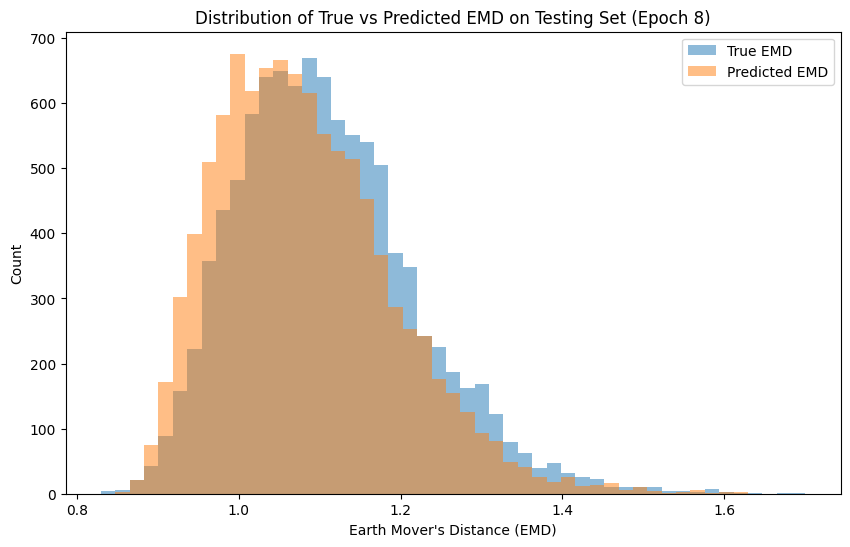

[Epoch 9/10] Train Loss: 0.4281, Val Loss: 0.4391


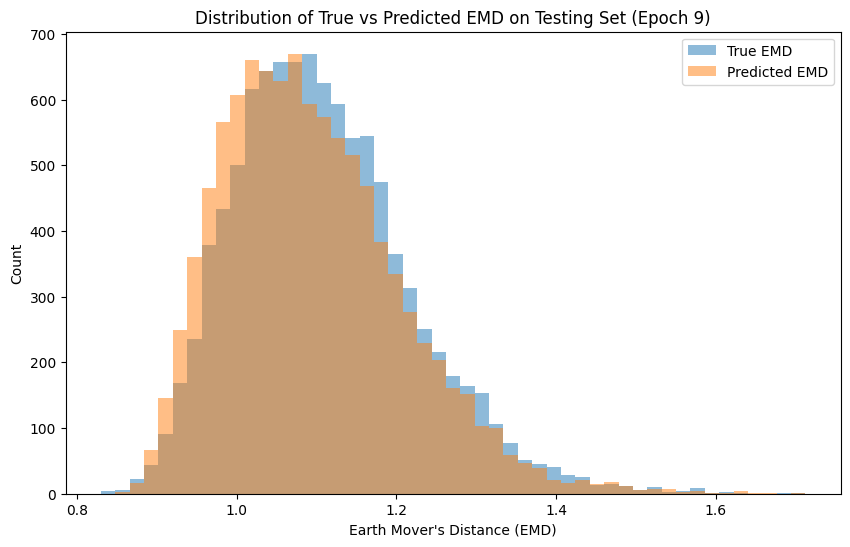

[Epoch 10/10] Train Loss: 0.4085, Val Loss: 0.5029


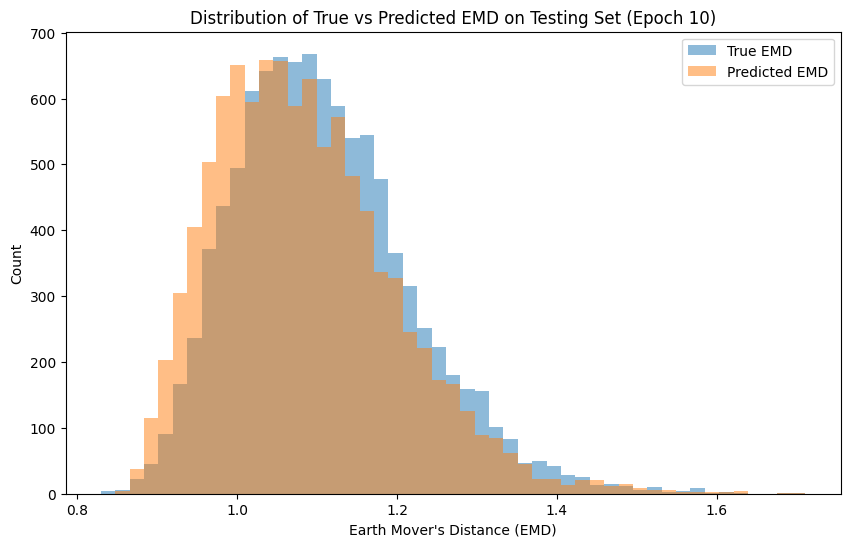

Training complete.


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = train_transformer_model(
        pairs_A, paris_B, emd_vals,
        batch_size=256,
        epochs=10,
        device=device
    )

In [24]:
model

CrossAttentionTransformer(
  (input_projection): Linear(in_features=3, out_features=256, bias=True)
  (layers): ModuleList(
    (0-3): 4 x ModuleDict(
      (self_attn_A): SelfAttentionBlock(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=256, bias=True)
        )
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (self_attn_B): SelfAttentionBlock(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff

In [89]:
event1 = bkg_data[1].cpu().numpy()
event2 = bkg_data[10].cpu().numpy()

In [90]:
emd_value = compute_emd(event1, event2)
emd_value

1.1418392304846614

In [91]:
event2.shape

(200, 3)

In [22]:
pred_emd = model(torch.Tensor(event1).to(device).unsqueeze(0), torch.Tensor(event2).to(device).unsqueeze(0))  # (batch_size,)

NameError: name 'model' is not defined

In [93]:
pred_emd

tensor([1.0964], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [19]:
dataset = EMDPairDataset(pairs_A, paris_B, torch.tensor(emd_vals, dtype=torch.float))

/tmp/maglowac/ipykernel_218330/2266328768.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = EMDPairDataset(pairs_A, paris_B, torch.tensor(emd_vals, dtype=torch.float))


In [20]:
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [21]:
true_emd_vals = []
pred_emd_vals = []


with torch.no_grad():
        for batch_A, batch_B, batch_emd in loader:
            batch_A = batch_A.to(device)
            batch_B = batch_B.to(device)
            batch_emd = batch_emd.to(device)

            pred_emd = model(batch_A, batch_B)
            # Reverse scaling to get original EMD values
            true_emd_vals.extend(batch_emd.cpu().numpy().reshape(-1, 1).flatten())
            pred_emd_vals.extend(pred_emd.cpu().numpy().reshape(-1, 1).flatten())

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(true_emd_vals, bins=50, alpha=0.5, label='True EMD')
plt.hist(pred_emd_vals, bins=50, alpha=0.5, label='Predicted EMD')
plt.xlabel('Earth Mover\'s Distance (EMD)')
plt.ylabel('Count')
plt.title('Distribution of True vs Predicted EMD on Testing Set')
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [98]:
#torch.save(model.state_dict(), "EMD_model.pth")